In [32]:
%matplotlib inline

In [33]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MAX_N_EXPOSURES, MIN_N_NEURONS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

In [8]:
def get_levy_exponent(Replay_traj):
    '''
    Get the levy exponent for replay trajectory
    Input (dictionary): Replay_traj
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::1]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

In [9]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))
#is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con'], level='animal')
is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                (epoch_info.exposure <= MAX_N_EXPOSURES) &
                is_animal
                )

In [18]:
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len = []
replay_ratio = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    speed = data['position_info'].speed.values
    is_running = speed > 10

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    sweep_len.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    steps = get_levy_exponent(Replay_traj)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of three standard deviations: {ratio}')
    
    replay_ratio.append(ratio)
        
        

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2


epochs:   4%|▍         | 1/24 [00:02<00:57,  2.48s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(22.2884689)
Ratio of steps that are out of three standard deviations: 0.014697876973326075
Animal: bon, Day: 3, Epoch: 4


epochs:   8%|▊         | 2/24 [00:04<00:48,  2.19s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(11.76425779)
Ratio of steps that are out of three standard deviations: 0.016070222822417286
Animal: bon, Day: 3, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:06<00:45,  2.17s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(16.99002008)
Ratio of steps that are out of three standard deviations: 0.05273933338792892
Animal: bon, Day: 4, Epoch: 2


epochs:  17%|█▋        | 4/24 [00:08<00:41,  2.10s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(15.56047097)
Ratio of steps that are out of three standard deviations: 0.01463860933211345
Animal: bon, Day: 4, Epoch: 4


epochs:  21%|██        | 5/24 [00:11<00:42,  2.23s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(14.39994842)
Ratio of steps that are out of three standard deviations: 0.01867881548974943
Animal: bon, Day: 4, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:13<00:39,  2.17s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(18.156145)
Ratio of steps that are out of three standard deviations: 0.03918507532589181
Animal: bon, Day: 5, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:15<00:39,  2.33s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(13.23850578)
Ratio of steps that are out of three standard deviations: 0.01313522825150732
Animal: bon, Day: 5, Epoch: 4


epochs:  33%|███▎      | 8/24 [00:18<00:37,  2.36s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.03582668)
Ratio of steps that are out of three standard deviations: 0.010664123461071614
Animal: bon, Day: 5, Epoch: 6


epochs:  38%|███▊      | 9/24 [00:20<00:35,  2.39s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(17.8299893)
Ratio of steps that are out of three standard deviations: 0.051671087533156496
Animal: bon, Day: 6, Epoch: 2


epochs:  42%|████▏     | 10/24 [00:23<00:33,  2.40s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(15.26332217)
Ratio of steps that are out of three standard deviations: 0.013596059113300493
Animal: bon, Day: 6, Epoch: 4


epochs:  46%|████▌     | 11/24 [00:25<00:31,  2.40s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.41731291)
Ratio of steps that are out of three standard deviations: 0.022052990639378073
Animal: bon, Day: 6, Epoch: 6


epochs:  50%|█████     | 12/24 [00:27<00:27,  2.30s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(19.40744284)
Ratio of steps that are out of three standard deviations: 0.04670398529534631
Animal: bon, Day: 7, Epoch: 2


epochs:  54%|█████▍    | 13/24 [00:30<00:26,  2.37s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(15.55994807)
Ratio of steps that are out of three standard deviations: 0.014003071641521366
Animal: bon, Day: 7, Epoch: 4


epochs:  58%|█████▊    | 14/24 [00:32<00:24,  2.44s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(11.7442669)
Ratio of steps that are out of three standard deviations: 0.017733990147783252
Animal: bon, Day: 7, Epoch: 6


epochs:  62%|██████▎   | 15/24 [00:34<00:21,  2.39s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(16.9197117)
Ratio of steps that are out of three standard deviations: 0.05108885417623817
Animal: bon, Day: 8, Epoch: 2


epochs:  67%|██████▋   | 16/24 [00:37<00:19,  2.38s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.56645469)
Ratio of steps that are out of three standard deviations: 0.018502704241389126
Animal: bon, Day: 8, Epoch: 4


epochs:  71%|███████   | 17/24 [00:39<00:16,  2.33s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.53054374)
Ratio of steps that are out of three standard deviations: 0.017462881760135395
Animal: bon, Day: 8, Epoch: 6


epochs:  75%|███████▌  | 18/24 [00:41<00:13,  2.29s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(13.7196317)
Ratio of steps that are out of three standard deviations: 0.030244468064547298
Animal: bon, Day: 9, Epoch: 2


epochs:  79%|███████▉  | 19/24 [00:44<00:11,  2.28s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(13.10165803)
Ratio of steps that are out of three standard deviations: 0.022006311243979407
Animal: bon, Day: 9, Epoch: 4


epochs:  83%|████████▎ | 20/24 [00:46<00:09,  2.34s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(11.79717438)
Ratio of steps that are out of three standard deviations: 0.01785200115174201
Animal: bon, Day: 9, Epoch: 6


epochs:  88%|████████▊ | 21/24 [00:48<00:06,  2.30s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(17.13021055)
Ratio of steps that are out of three standard deviations: 0.03491046492525053
Animal: bon, Day: 10, Epoch: 2


epochs:  92%|█████████▏| 22/24 [00:50<00:04,  2.30s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(12.68517656)
Ratio of steps that are out of three standard deviations: 0.01823065028078457
Animal: bon, Day: 10, Epoch: 4


epochs:  96%|█████████▌| 23/24 [00:53<00:02,  2.32s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(10.50598165)
Ratio of steps that are out of three standard deviations: 0.018861523848293642
Animal: bon, Day: 10, Epoch: 6


epochs: 100%|██████████| 24/24 [00:55<00:00,  2.32s/it]

Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(14.22608031)
Ratio of steps that are out of three standard deviations: 0.0341726618705036


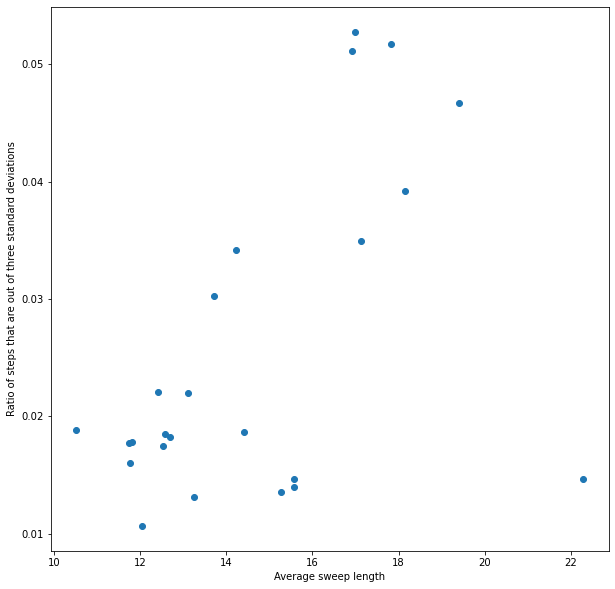

In [34]:
#plot sweep_len against replay_ratio
plt.figure(figsize=(10,10))
plt.scatter(np.array(sweep_len), np.array(replay_ratio))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio of steps that are out of three standard deviations')
plt.show()
    



In [37]:
speed_info = data['position_info'].speed

#save the speed_info, which is pandas.core.series.Series
speed_info.to_pickle(os.path.join(DATA_DIR, 'speed_info.pkl'))
